## Quotations indicate the career success of public figures
**ChillDataGroup: Zihan Wu, Yinhao Wang, Yihang Chen**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load QuoteBank Dataset
We refer to the pipeline provided in Google Colab to load the quotations from 2015 to 2020.

Due to the large size of data, when loading them, we just load the data said by the senate election since 2015 candidates. The dataset for senate elections is obtained from MIT Election Data and Science Lab [1].

We also provide the codes for loading these senate candidate quotations below, but those are run ahead in google colab (takes around 30min for each year's data). We did not re-run them here. It contains the senate election results for all candidates

[1] MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2020", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V5.

In [2]:
# Pipeline obtained from the course google colab
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [3]:
# Load the Senate Election Result data 
import pandas as pd
senate_file = 'SenateData/1976-2020-senate.csv'
senate_election = pd.read_csv(senate_file, encoding= 'unicode_escape')
senate_election.sample(4) # demonstrate the format of election data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
363,1980,OHIO,OH,39,31,24,US SENATE,statewide,gen,False,JAMES E. BETTS,REPUBLICAN,False,total,1137695,4027303,False,20210114,REPUBLICAN
1196,1994,MAINE,ME,23,11,2,US SENATE,statewide,gen,False,THOMAS H. ANDREWS,DEMOCRAT,False,total,186042,511733,False,20210114,DEMOCRAT
3295,2018,MAINE,ME,23,11,2,US SENATE,statewide,gen,False,"ANGUS S. KING, JR.",INDEPENDENT,False,total,344575,634409,False,20210114,OTHER
959,1990,NEW JERSEY,NJ,34,22,12,US SENATE,statewide,gen,False,LOUIS M. STEFANELLI,LIBERTARIAN,False,total,13988,1938454,False,20210114,LIBERTARIAN


Here, we only choose the candidate running for elections since 2016, because the supported Quotebank data goes back to 2015

In [4]:
# Load the names of candidates since 2016
# The NaN names are dropped, and repeated names are dropped
def delete_middle_name(name): # delete middle name
  name_split = name.upper().split()
  if len(name_split) > 2:
    senate_delete_middle_name = name_split[0] + ' ' + name_split[-1]
    return senate_delete_middle_name
  return name

# To address the variation of names, we use this function to determine whether the speaker name matches the first and 
# last name of any senate candidates. In this way, we can find speakers with different name writing style like:
# 'Senate Lindsey Graham', 'Lindsey Olin Graham', 'Lindsey O. Graham' (they all indicate the same candidate)

# The function below takes in a speaker name and a list of senate names (already split into first and last name)
# It returns a boolean whether the speaker is a senate, and the name of senate (in the form of first + last name) if true
def isSenate(name,senate_names):
  name_set = set(name.upper().split())
  for i in range(len(senate_names)):
    if senate_names[i] <= name_set:
      return (True, i)
  return (False, None)

senate_candidates = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed'])['candidate'].unique()
senate_candidates_splitted = list(map(lambda senate: set(delete_middle_name(senate).split()), senate_candidates))
senate_candidates_splitted[1:10]

[{'RICHARD', 'SHELBY'},
 {'JOE', 'MILLER'},
 {'GIANOUTSOS', 'TED'},
 {'METCALFE', 'RAY'},
 {'MARGARET', 'STOCK'},
 {'BRECK', 'CRAIG'},
 {'LISA', 'MURKOWSKI'},
 {'ANTHONY', 'CAMBONI'},
 {'ANN', 'KIRKPATRICK'}]

In [5]:
#Sanity Check: all names at least have a first and last name
for split in senate_candidates_splitted:
    assert(len(split) > 1)
print('there are total {} names'.format(len(senate_candidates_splitted)))

there are total 439 names


**We do not run the cell below because takes too long.** We have run those on google colab to load the quotation data we need

In [ ]:
# Load each year's data, filtering out the quotations said by senates
# We have considered the different writing styles of name. We extract the quote as long as the speaker has the same
# first name and last name as a senate
import bz2
import json

path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2' 
path_to_out = '/content/drive/MyDrive/MyQuoteBank/quotes-{}-senates-said.json.bz2'

for year in range(2015, 2021):
  print('... Start reading quotations in year ' + str(year))
  with bz2.open(path_to_file.format(year), 'rb') as s_file:
      with bz2.open(path_to_out.format(year), 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              issenate = isSenate(instance['speaker'], senate_candidates_splitted)
              if issenate[0]:
                instance['speaker'] = senate_candidates[issenate[1]] # use name from the "1976-2020-senate.csv" as the standard name.
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

# Load each year's data, filtering out the quotations that mention senates
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2'
path_to_out = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention.json.bz2'

senate_candidates = list(map(lambda x:x.title(), senate_candidates))

for year in range(2016,2021):
    print('... Start processing quotations in year {}'.format(year))
    with bz2.open(path_to_file.format(year), 'rb') as s_file:
        with bz2.open(path_to_out.format(year), 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)
                is_senate = isSenate(instance['quotation'], senate_candidates_splitted)
                if is_senate[0]:
                    instance['mention']=senate_candidates[is_senate[1]]
                    urls = instance['urls'] # extracting list of links
                    domains = []
                    for url in urls:
                        tld = get_domain(url)
                        domains.append(tld)
                    instance['domains'] = domains # updating the sample with domain name
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
    print('... End processing quotations in year {}'.format(year))

## 1. Process Senate Candidate Data
**1.1** In this section, we load the information of senate candidates (since 2016) and their election information.

In [6]:
# First, we get the election information of the candidates since 2016 (again, we drop NaN and repeated names)
candidate_info = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed']).drop_duplicates(subset=['candidate'], ignore_index=True)

In [7]:
# Load the stored quotations said by senate candidates since 2015 (by year)
senate_quote_20 = pd.read_json('SenateData/quotes-2020-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_19 = pd.read_json('SenateData/quotes-2019-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_18 = pd.read_json('SenateData/quotes-2018-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_17 = pd.read_json('SenateData/quotes-2017-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_16 = pd.read_json('SenateData/quotes-2016-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_15 = pd.read_json('SenateData/quotes-2015-senates-said.json.bz2', lines=True, compression='bz2')

In [8]:
# Concatenate data across all years and display the format of quotation data
annual_frames = [senate_quote_15, senate_quote_16, senate_quote_17, senate_quote_18, senate_quote_19, senate_quote_20]
candidate_quotes = pd.concat(annual_frames).reset_index()
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
104216,3666,2017-07-27-122423,The BDS movement has moved far beyond the noti...,Cory Gardner,[Q1135774],2017-07-27 18:54:29,1,"[[Cory Gardner, 0.9026], [None, 0.0799], [Tim ...",[http://www.haaretz.com/us-news/1.803827],E,[com]
311305,23405,2018-02-01-080977,It's not like it's going to fall like manna fr...,John Cornyn,[Q719568],2018-02-01 11:30:00,1,"[[John Cornyn, 0.6654], [None, 0.3255], [Presi...",[http://hillcountrynews.com/stories/at-koch-ne...,E,[com]
394505,106605,2018-02-14-092983,No state has felt the effects of this epidemic...,Shelley Moore Capito,"[Q459618, Q47506415]",2018-02-14 00:00:14,3,"[[Shelley Moore Capito, 0.8532], [None, 0.1452...","[http://lite.washingtonexaminer.com/?p=8989, h...",E,"[com, com, com]"
477142,189242,2018-05-17-157388,Woe be to the opponent he felt didn't respect ...,John McCain,[Q10390],2018-05-17 09:02:11,2,"[[John McCain, 0.7938], [None, 0.2062]]",[http://rollcall.com/news/politics/mccains-adv...,E,"[com, com]"


Since QuoteBank may extract different number of total quotes at different time. An increase in quotations may just be caused by an increase of quotes extracted by Quotebanks. So, we use the total quotation number in QuoteBank to normalize our data

In [9]:
# read the quote number data for each month

import csv
with open('SenateData/quote_num.csv','r') as inFile:
    reader = csv.DictReader(inFile)
    for row in reader:
        quote_num = dict(row)
quote_num = pd.Series({k:int(v) for k, v in quote_num.items()})
quote_num

2015-01    1661137
2015-02    1659518
2015-03    1867911
2015-04    1522315
2015-05    1136152
            ...   
2019-12    1565321
2020-01    1732238
2020-02    1599019
2020-03    1323347
2020-04     589845
Length: 64, dtype: int64

In [10]:
# we use 10^6/total_quote_num as normalize factor

candidate_quotes['normalize_factor'] = candidate_quotes['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes['normalize_quotes'] = candidate_quotes['numOccurrences']*candidate_quotes['normalize_factor']
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes
75945,75945,2016-04-28-043682,I gave the [ explanation of ] why we made the ...,Ted Cruz,[Q2036942],2016-04-28 00:00:00,9,"[[Ted Cruz, 0.681], [None, 0.2312], [Donald Tr...",[http://abcnews.com/Politics/ted-cruz-carly-fi...,E,"[com, com, com, com, com, com, com, com, com]",0.939819,8.458368
542446,12470,2020-01-26-039239,The American people want a health care system ...,Bernie Sanders,[Q359442],2020-01-26 00:00:00,1,"[[Bernie Sanders, 0.6035], [None, 0.3609], [El...",[https://www.foxbusiness.com/money/bernie-sand...,E,[com],0.577288,0.577288
552729,22753,2020-01-22-018847,Every day we're here doing this is a day that ...,Lindsey Graham,[Q22212],2020-01-22 22:00:33,2,"[[Lindsey Graham, 0.5285], [None, 0.4122], [Pr...",[http://www.breitbart.com/politics/2020/01/22/...,E,"[com, com]",0.577288,1.154576
62266,62266,2016-09-13-011173,Balancing the budget is paramount to the conti...,Mike Crapo,[Q734319],2016-09-13 09:16:48,1,"[[Mike Crapo, 0.8709], [None, 0.1291]]",[http://www.spokesman.com/blogs/hbo/2016/sep/1...,E,[com],0.395064,0.395064


**1.2** We group the total number of quotations by speaker and dates. By doing so, we can visualize the change of quoted numbers as time goes on. Below, we take Bernie Sanders as an example.

In [11]:
# Clean the names by taking only upper case
# Group the candidate total number of normalized quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_quotes_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_byday

speaker          date_only 
AARON JAMES      2016-02-18    5.757202
                 2016-05-10    0.877068
                 2016-05-12    0.877068
                 2016-05-18    4.823876
                 2016-05-25    0.877068
                                 ...   
ZAK RINGELSTEIN  2018-10-30    5.125275
                 2018-11-01    2.381878
                 2018-11-05    0.476376
                 2018-11-07    0.476376
                 2019-03-21    0.503878
Name: normalize_quotes, Length: 79165, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

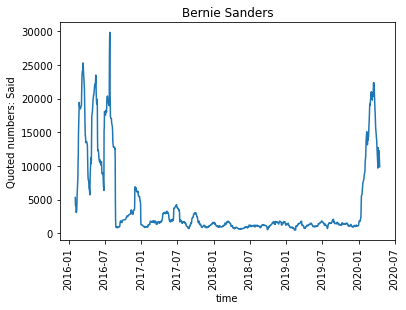

In [12]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Quoted numbers: Said')
plt.title('Bernie Sanders')

**1.3** We compute the total number of quotations until their election. The election dataset only contains the year of election. However, since the U.S. Senate elections always take place in the first week of November, we just compute the total number of quotations until November.1st of the election year.

In [13]:
# Add the election day corresponding to each candidate speaker
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes['election_day'] = candidate_quotes['speaker'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes['election_day'] = pd.to_datetime(candidate_quotes['election_day'])

In [14]:
# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

In [15]:
# We group the number of quotations by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

Pearson coefficient: 0.6483833179884133, p value: 7.575062514519927e-23


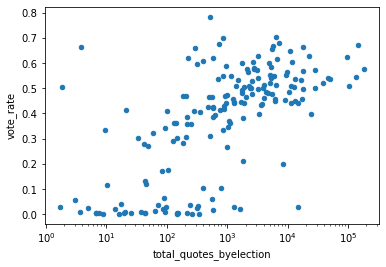

In [16]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is a positive correlation between quotations and vote_rate with p value < 0.05. The more a candidate was quoted before the election, the higher the voting rate he or she got.

**1.4** We can also apply the analysis on quotations that mention senates.

In [17]:
# Load the stored quotations mention senate candidates since 2015 (by year)
senate_quote_20_mention = pd.read_json('SenateData/quotes-2020-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_19_mention = pd.read_json('SenateData/quotes-2019-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_18_mention = pd.read_json('SenateData/quotes-2018-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_17_mention = pd.read_json('SenateData/quotes-2017-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_16_mention = pd.read_json('SenateData/quotes-2016-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_15_mention = pd.read_json('SenateData/quotes-2015-senates-mention.json.bz2', lines=True, compression='bz2')

In [18]:
# Concatenate data across all years and display the format of quotation data
annual_frames_mention = [senate_quote_15_mention, senate_quote_16_mention, senate_quote_17_mention, senate_quote_18_mention, senate_quote_19_mention, senate_quote_20_mention]
candidate_quotes_mention = pd.concat(annual_frames_mention)
candidate_quotes_mention.sample(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains
11874,2018-05-30-001306,A few years back I flew out to Arizona to meet...,Jamie Foxx,[Q171905],2018-05-30 09:18:00,3,"[[Jamie Foxx, 0.635], [None, 0.2633], [Michael...",[http://www.breitbart.com/news/jamie-foxx-cast...,E,Todd C. Young,"[com, com, com]"
522,2018-05-23-075466,Marco Rubio on Donald Trump's China approach: ...,None,[],2018-05-23 04:00:11,1,"[[None, 0.3771], [Ron DeSantis, 0.3455], [Matt...",[http://floridapolitics.com/archives/264097-su...,E,Marco Rubio,[com]
2938,2015-10-08-045271,"If the caucuses were today, Bernie Sanders wou...",Steve Deace,[Q59387171],2015-10-08 16:18:53,4,"[[Steve Deace, 0.7621], [None, 0.2249], [Hilla...",[http://dailycaller.com/2015/10/08/iowa-radio-...,E,Bernie Sanders,"[com, com, com, com]"
2341,2018-04-21-034440,I'm not surprised that key party loyalists end...,None,[],2018-04-21 23:22:41,2,"[[None, 0.5674], [Angie Craig, 0.4238], [Jason...",[https://www.twincities.com/2018/04/21/jason-l...,E,Jason Lewis,"[com, org]"


In [19]:
# format the date
candidate_quotes_mention['date_only'] = candidate_quotes_mention['date'].dt.date
# change the name to upper format
candidate_quotes_mention['mention'] = candidate_quotes_mention['mention'].str.upper()

# Normalize the quotes
candidate_quotes_mention['normalize_factor'] = candidate_quotes_mention['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes_mention['normalize_quotes'] = candidate_quotes_mention['numOccurrences']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes
10456,2016-02-20-004371,"Arizona is still a conservative state, so I do...",Kelli Ward,[Q16207584],2016-02-20 23:00:44,1,"[[Kelli Ward, 0.8825], [None, 0.1127], [John M...",[http://www.wnd.com/2016/02/will-this-feisty-c...,E,ANN KIRKPATRICK,[com],2016-02-20,0.959534,0.959534
10345,2019-04-25-074584,When you look at things like Bernie Sanders ru...,Lara Trump,[Q35703322],2019-04-25 00:00:00,1,"[[Lara Trump, 0.5356], [Joe Biden, 0.2935], [N...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E,BERNIE SANDERS,[com],2019-04-25,0.601280,0.601280
7437,2017-03-14-120526,We've had presidents assassinated before in th...,Marco Rubio,[Q324546],2017-03-14 14:06:33,2,"[[Marco Rubio, 0.8805], [None, 0.1169], [Donal...",[http://feeds.nydailynews.com/~r/nydnrss/sport...,E,MARCO RUBIO,"[com, com]",2017-03-14,0.403952,0.807904
10649,2018-04-20-164406,"When Sharpe James became the mayor, they gave ...",Ras Baraka,[Q7294641],2018-04-20 10:59:53,2,"[[Ras Baraka, 0.5156], [None, 0.4844]]",[https://www.tapinto.net/articles/baraka-chane...,E,CORY BOOKER,"[net, net]",2018-04-20,0.386958,0.773915
2708,2018-06-22-125936,You can talk again about him denying any knowl...,Joe Scarborough,"[Q1280288, Q6212213]",2018-06-22 11:59:29,1,"[[Joe Scarborough, 0.8258], [None, 0.1742]]",[https://www.thenewcivilrightsmovement.com/201...,E,DAVID DUKE,[com],2018-06-22,0.482000,0.482000


In [20]:
# obtain normalized quotations by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16    0.601997
                  2015-08-04    0.473512
                  2015-12-11    0.955093
                  2017-02-12    2.080072
                  2017-05-28    0.401338
                                  ...   
WILLIE L. WILSON  2019-03-30    0.503878
                  2019-07-16    0.668486
                  2019-11-04    0.542426
ZAK RINGELSTEIN   2018-06-22    0.482000
                  2018-10-24    0.427106
Name: normalize_quotes, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

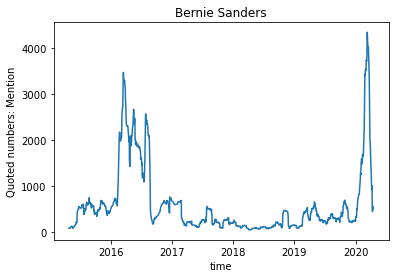

In [21]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

In [22]:
# Add the election day corresponding to each candidate mentioned
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes_mention['mention']=candidate_quotes_mention.mention.map(lambda x:x.upper())
candidate_quotes_mention['election_day'] = candidate_quotes_mention['mention'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes_mention['election_day'] = pd.to_datetime(candidate_quotes_mention['election_day'])
candidate_quotes_mention.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day
0,2015-05-17-016225,I really like Bernie Sanders and his policies ...,None,[],2015-05-17 07:09:22,1,"[[None, 0.81], [Bernie Sanders, 0.19]]",[http://dailykos.com/story/2015/05/15/1384917/...,E,BERNIE SANDERS,[com],2015-05-17,0.880164,0.880164,2018-11-01
1,2015-08-25-018582,Elizabeth Warren does have a thumb on the puls...,Bakari Sellers,[Q4849014],2015-08-25 10:02:35,4,"[[Bakari Sellers, 0.8813], [None, 0.1075], [El...",[http://www.kspr.com/news/politics/does-elizab...,E,ELIZABETH A. WARREN,"[com, com, com, com]",2015-08-25,0.473512,1.894046,2018-11-01
2,2015-03-11-040221,I'll invoke the marital privilege on some of i...,Mike Coffman,[Q547218],2015-03-11 17:09:31,1,"[[Mike Coffman, 0.4786], [None, 0.3104], [Tom ...",[http://www.huffingtonpost.com/jason-salzman/r...,E,CORY GARDNER,[com],2015-03-11,0.535357,0.535357,2020-11-01
3,2015-09-24-081451,Richard Burr truly is North Carolina's `Invisi...,None,[],2015-09-24 02:04:45,1,"[[None, 0.7571], [Richard Burr, 0.182], [Paul ...",[http://www.wcti12.com/news/Ross-leaves-job-po...,E,RICHARD BURR,[com],2015-09-24,0.447555,0.447555,2016-11-01


Pearson coefficient: 0.5320764453359699, p value: 1.1343252830666171e-22


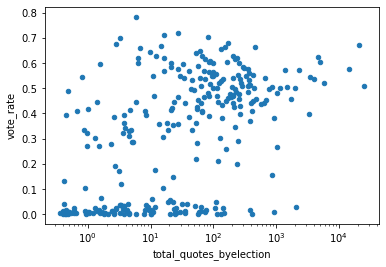

In [23]:
from scipy.stats import pearsonr

# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

# We group the number of normalized quotations before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is also a positive correlation between number of mentioned quotations and vote_rate with p value < 0.05.

## 2. Weigh the quotations by readership
We are aware of the different reading statistics of different media. We try to weigh the quotations by the readership of the source media.

**2.1** First, we sample 50k quotes and look at the source media of those quotations. This would give us a feel of how much media is covered by QuoteBank and which media appear most often. To balance the data said by candidates and the data mentioning candidates, we sample the 50k quotes according to the ratio of total data in 'candidate_quotes' and 'candidate_quotes_mention'

In [24]:
# sample 50k quotes and see where quotes are published
candidate_quotes_mention.reset_index(inplace=True) # Reset index of mention dataset
sample_n = 50000
said_n = len(candidate_quotes.index) # total number of quotes said by candidates
mention_n = len(candidate_quotes_mention.index) # total number of quotes mentioning candidates
mention_sample_n = int(sample_n * mention_n/(mention_n + said_n))
said_sample_n = sample_n - mention_sample_n
print('we sample {} quotes said by candidates and {} quotes mentioning candidates'.format(said_sample_n, mention_sample_n))

we sample 43127 quotes said by candidates and 6873 quotes mentioning candidates


In [25]:
# We extract the domains from two data set based on the ratio computed above
total_domains = []
said_sample = candidate_quotes.sample(said_sample_n) # sample from quotes said by candidates
# We extract web domains from the url
for i in said_sample.index:
    urls = said_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

mention_sample = candidate_quotes.sample(mention_sample_n) # sample from quotes said by candidates
# We use the same pipeline to extract domain
for i in mention_sample.index:
    urls = mention_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

**DONOT rerun the below two cells, in case the distribution changes!**

In [ ]:
# Count the frequency of media occurences in quotation dataset
from collections import Counter
domain_count = Counter(total_domains).most_common()
print("----top 30 news agency/publisher:\n ", domain_count[0:30])
print('----number of news agency covered:', len(domain_count))


Among 50k samples, there are over 4000 different website domains, indicating a sufficiently wide coverage of media. So the quotations can be an indicator of public exposure. Besides, we observe an exponential decrease of counts in the database.

In [ ]:
# Plot the histogram characterizing the frequency of each media appearing
_, y_counts = zip(*domain_count)
plt.hist(y_counts, bins=20)
plt.yscale('log')
plt.ylabel('number of media')
plt.xlabel('occurences in sampled quote data')

**Do Not Re run the cell below! In case sample changes**

10 randomly selected news agency/publisher except the top 30:
  [('bakersfield', 11), ('wtkr', 37), ('go', 444), ('navytimes', 62), ('advertiser-tribune', 8), ('circleofblue', 1), ('nbcphiladelphia', 159), ('malaymail', 14), ('illawarramercury', 12), ('hawaiinewsnow', 283)]

In [ ]:
# Randomly sample 10 other media, to be used for estimating the rest readership
#media_ind = np.random.randint(31, len(domain_count), size=10)
#print("10 randomly selected news agency/publisher except the top 30:\n ", [domain_count[i] for i in media_ind])

The distribution is heavy-tailed, with only a few big media like CNN and Fox News occurring frequently. Most media occurs no more than 1.5% among all quotations. So, we think it is sufficient to just weigh the quotations extracted from those frequently occurring media. Moreover, it is very difficult to automatically find media's reading statistics (or other indicators of popularity) just based on the url major domain name. We could not think of a way to do so. Neither could we find an open dataset helping us. Therefore, we decide to manually look up the readership of those top 30 new agencies. For the rest media, we will sample 10 media from them and manually look up the reading statistics. We will take the average readership of those 10 media to represent the readership of the rest media. This will take up some time, so we plan to finish those manual work in the following weeks (see proposed timeline). As a result, we do not include any exposure level (quotation weighted by media readership) in Milestone 2. Instead, we just use the number of quotations (assuming all media offer the same public exposure).

**2.2** We manually search the total website visits of top 30 news agencies of the 10 randomly selected agencies among the rest. We could not find the data of some websites, so we use the median of others to fill it.

In [26]:
weight_file = 'SenateData/WebsiteVisit.csv'
weight_df = pd.read_csv(weight_file)
# Fill the NaN value by median (which avoid effect from outliers)
weight_df.loc[:, ['total_view_in_US']] = weight_df[['total_view_in_US']].fillna(weight_df[['total_view_in_US']].median())
weight_df.head(5) # demonstrate the format website view data for weight


,webdomain,media,total_view_in_US
0,KRMG,KRMG,0.11
1,news965,WBDO,21.68
2,wokv,WOKV,0.09
3,msn,MSN,323.98
4,breitbart,Breitbart,42.19


In [27]:
# Get the views for the 10 randomly selected agencies
random_file = 'SenateData/RandomVisit.csv'
random_df = pd.read_csv(random_file)
# We take the median of total_US_view of the 10 agencies, as view for other agencies
random_view = random_df['total_view_in_US'].median()
print('The median value of total views of the 10 agencies is {}'.format(random_view))

The median value of total views of the 10 agencies is 0.675


Then, we add those weights to the 'candidate_quotes' and 'candidate_quotes_mention'

In [28]:
# assign weights to quotes said by candidates
weight_dict = dict(zip(weight_df['webdomain'], weight_df['total_view_in_US']))
n_hit = 0
for i in candidate_quotes.index:
    urls = candidate_quotes.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes.at[i,'views'] = weight_ 
print('For quotes said by candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes said by candidates, we found 594482 numbers of quotation occurrences from top 30


In [29]:
# Multiply views by normalization factors
candidate_quotes['normalize_views'] = candidate_quotes['views']*candidate_quotes['normalize_factor']
candidate_quotes.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views
299521,11621,2018-06-07-132064,When businesses advertise products at a fracti...,PATRICK MORRISEY,[Q7147254],2018-06-07 00:00:00,2,"[[Patrick Morrisey, 0.7936], [None, 0.2064]]",[http://wvrecord.com/stories/511448284-ag-s-of...,E,"[com, net]",0.482000,0.963999,2018-06-07,2018-11-01,1.350,0.650700
211990,111440,2017-03-26-023781,I saw you repeat yourself five times five seco...,MARCO RUBIO,[Q324546],2017-03-26 19:28:24,1,"[[Marco Rubio, 0.6701], [None, 0.21], [Donald ...",[http://redalertpolitics.com/2017/03/26/rememb...,E,[com],0.403952,0.403952,2017-03-26,2016-11-01,0.675,0.272667
219221,118671,2017-07-18-003350,add to more uncertainty.,ROB PORTMAN,[Q926069],2017-07-18 17:31:16,1,"[[Rob Portman, 0.8234], [None, 0.1163], [Bob C...",[http://people.com/politics/gop-plan-to-repeal...,E,[com],0.418827,0.418827,2017-07-18,2016-11-01,0.675,0.282708
420831,132931,2018-06-13-013360,But for the rest of us who are watching and kn...,MARCO RUBIO,[Q324546],2018-06-13 12:02:00,16,"[[Marco Rubio, 0.6203], [None, 0.2701], [Bob C...",[http://www.princegeorgecitizen.com/washington...,E,"[com, com, com, com, com, com, com, com, com, ...",0.482000,7.711996,2018-06-13,2016-11-01,10.800,5.205597
549379,19403,2020-01-07-079515,underlying technology providing information se...,DIANNE FEINSTEIN,[Q230733],2020-01-07 16:48:00,1,"[[Dianne Feinstein, 0.528], [None, 0.4241], [S...",[http://msn.com/en-au/news/other/fbi-asks-appl...,E,[com],0.577288,0.577288,2020-01-07,2018-11-01,323.980,187.029727


In [30]:
# assign weights to quotes mentioning candidates
n_hit = 0
for i in candidate_quotes_mention.index:
    urls = candidate_quotes_mention.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes_mention.at[i,'views'] = weight_ 
print('For quotes mentioning candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes mentioning candidates, we found 63187 numbers of quotation occurrences from top 30


In [31]:
# Multiply views by normalization factors
candidate_quotes_mention['normalize_views'] = candidate_quotes_mention['views']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day,views,normalize_views
69708,267,2019-06-19-051342,Is Bernie Sanders Finished?,None,[],2019-06-19 16:41:30,4,"[[None, 0.8089], [Elizabeth Warren, 0.1619], [...",[https://vtdigger.org/2019/06/19/is-elizabeth-...,E,BERNIE SANDERS,"[org, org]",2019-06-19,0.551375,2.205498,2018-11-01,1.350,0.744356
73985,4544,2019-09-25-018907,Elizabeth Warren surges ahead of Joe Biden in ...,None,[],2019-09-25 00:00:00,1,"[[None, 0.6056], [Marco Rubio, 0.3222], [Eliza...",[https://floridapolitics.com/archives/306319-s...,E,ELIZABETH A. WARREN,[com],2019-09-25,0.543010,0.543010,2018-11-01,0.675,0.366531
44368,12058,2017-11-20-030570,"He's weak on crime, he's weak on borders, he's...",Kellyanne Conway,[Q6386365],2017-11-20 16:25:13,1,"[[Kellyanne Conway, 0.6057], [None, 0.1863], [...",[http://www.mo4ch.com/kellyanne-conway-inexpli...,E,DOUG JONES,[com],2017-11-20,0.380549,0.380549,2020-11-01,0.675,0.256871
71353,1912,2019-08-01-018581,"Had those segregationists had their way, I wou...",Kamala Harris,[Q10853588],2019-08-01 00:00:00,12,"[[Kamala Harris, 0.5112], [Joe Biden, 0.3486],...",[https://ewn.co.za/2019/08/01/biden-and-harris...,E,CORY BOOKER,"[co.za, com, com, com, com, ie, com, com, us, ...",2019-08-01,0.579021,6.948248,2020-11-01,7.765,4.496096
55571,7567,2018-05-22-005217,America's Public Television Stations could not...,Kirsten Gillibrand,[Q22222],2018-05-22 14:56:07,1,"[[Kirsten Gillibrand, 0.8418], [None, 0.1582]]",[https://madisoncountycourier.com/?p=93830],E,KIRSTEN E. GILLIBRAND,[com],2018-05-22,0.402776,0.402776,2018-11-01,0.675,0.271874


**2.3** We repeat the protocol in section **1.2-1.3** to examine the effect of weighted quotations by candidates on their election results 

In [32]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_views_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_views'].sum()
candidate_views_byday

speaker          date_only 
AARON JAMES      2016-02-18    3.886111
                 2016-05-10    0.592021
                 2016-05-12    0.592021
                 2016-05-18    3.256116
                 2016-05-25    0.592021
                                 ...   
ZAK RINGELSTEIN  2018-10-30    3.459560
                 2018-11-01    1.607768
                 2018-11-05    0.321554
                 2018-11-07    0.321554
                 2019-03-21    0.340118
Name: normalize_views, Length: 79165, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

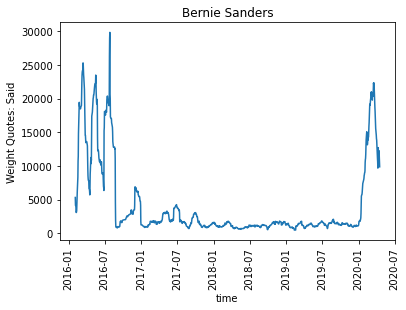

In [33]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Weight Quotes: Said')
plt.title('Bernie Sanders')

In [34]:
# We group weighted quotations (audience views) by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
views_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_views'].sum())
views_byelection.rename(columns = {'normalize_views': 'views_byelection'}, inplace=True)

Pearson coefficient: 0.6463664020545221, p value: 1.133606340518867e-22


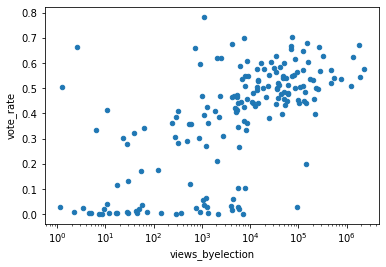

In [35]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
views_byelection['vote_rate'] = views_byelection.index.map(candidate_info_byname['vote_rate'])
views_vote = views_byelection.plot.scatter(x = 'views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(views_byelection['views_byelection']), views_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')


We notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.3** (where we did not weigh the quotes by website views). 

**2.4** We repeat the protocol in section **1.4** to examine the effect of weighted quotations mentioning candidates on their election results

In [36]:
# obtain normalized views by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_views'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16      0.406348
                  2015-08-04    153.408265
                  2015-12-11      0.644688
                  2017-02-12      1.404049
                  2017-05-28      0.270903
                                   ...    
WILLIE L. WILSON  2019-03-30      0.340118
                  2019-07-16     28.203418
                  2019-11-04     11.759805
ZAK RINGELSTEIN   2018-06-22      0.325350
                  2018-10-24      0.288297
Name: normalize_views, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

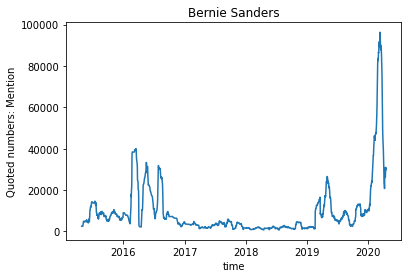

In [37]:
# For example, we can visualize the normalized view changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

Pearson coefficient: 0.5944534670274673, p value: 3.416648866161509e-29


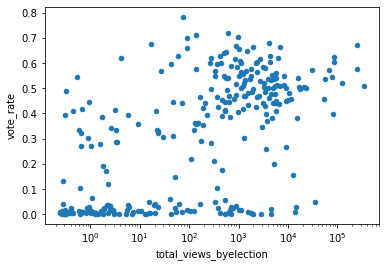

In [38]:
from scipy.stats import pearsonr

# We group the number of normalized views before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_views'].sum())
tot_quotes_byelection.rename(columns = {'normalize_views': 'total_views_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_views_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

Again, we notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.4** (where we did not weigh the quotes by website views). 

## 3. Features for Prediction Model
In the proposal, we decide to build a model predicting election results based on quotation data. Here, we preprocess the quote data and candidate data to generate the features for training our model.

The first feature is the change of quotation number over time. We will also use this for clustering analysis in proposed question 3.

In [ ]:
date_start=pd.to_datetime('2015-01-01', format='%Y-%m-%d') 
all_date = (pd.to_datetime('2020-12-31', format='%Y-%m-%d') - date_start).days # number of days.
candidate_quotes_name = candidate_quotes_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_feature = pd.DataFrame(np.zeros([all_date,len(candidate_quotes_name)]), columns=candidate_quotes_name) # initialize frequency vector

for candidate in candidate_quotes_name:
    candidate_mention = candidate_quotes_byday[candidate]
    for date in candidate_mention.index:
        date2days = (pd.to_datetime(date, format='%Y-%m-%d') - date_start).days # convert date to num of days w.r.t. start date
        candidate_quotes_feature[candidate].iloc[date2days] = candidate_mention.loc[date]

In [ ]:
candidate_quotes_byday

We also include the party affiliation of each candidate. Moreover, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the election from 2016 to 2021, we will use the 2016 presidential election data for the senate election from 2016 to 2019, and use the 2020 presidential election data for the senate election from 2020 to 2021.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [42]:
# We load 2016 and 2020 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president20 = president[president['year'] == 2020].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3716,2016,WASHINGTON,WA,53,91,73,US PRESIDENT,"KENNEDY, ALYSON",SOCIALIST WORKERS,False,4307,3317019,20210113,NaN,OTHER
3681,2016,TENNESSEE,TN,47,62,54,US PRESIDENT,"CLINTON, HILLARY",DEMOCRAT,False,870695,2508027,20210113,NaN,DEMOCRAT
3712,2016,WASHINGTON,WA,53,91,73,US PRESIDENT,"JOHNSON, GARY",LIBERTARIAN,False,160879,3317019,20210113,NaN,LIBERTARIAN
3397,2016,ALABAMA,AL,1,63,41,US PRESIDENT,"JOHNSON, GARY",LIBERTARIAN,False,44467,2123372,20210113,NaN,LIBERTARIAN


In [43]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
president20['vote_rate'] = president20['candidatevotes']/president20['totalvotes']

In [44]:
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty20 = president20.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [45]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
features = candidate_info_byname[['party_simplified', 'vote_rate']].copy()
for name in features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if candidate_info_byname.loc[name, 'year'] < 2020: #for candidate before 2020
        if party_ in vote_byparty16[state_].index:  #check whether the affiliated party is in recent president election
            features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0
    else:
        if party_ in vote_byparty20[state_].index: 
            features.loc[name, 'party_vote_rate'] = vote_byparty20[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0

# 4. statistics of sentence complexity

We also calculated the average length of sentence and word of each quotation. This information may be used in our analysis about speech style (question 6).

In [32]:
# calculate average sentence length (by word number)
import re
candidate_quotes['split_quotation']=candidate_quotes.quotation.map(lambda x:re.split(r'\.|!|\?',x))
candidate_quotes['split_quotation']=candidate_quotes.split_quotation.map(lambda x:list(filter(None, x))) # remove empty string
candidate_quotes['avg_sentence_length'] = candidate_quotes.split_quotation.map(lambda x:np.mean(list(map(lambda s:len(s.split()), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000


In [33]:
# calculate average word lenghth for each quotation
candidate_quotes['split_words'] = candidate_quotes.quotation.map(lambda x:x.split())
candidate_quotes['avg_word_length'] = candidate_quotes.split_words.map(lambda x:np.mean(list(map(lambda w:len(w), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length,split_words,avg_word_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000,"[..., a, great, day, for, veterans, here, in, ...",4.318182
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333,"[', It, is, not, now,, nor, has, it, ever, bee...",3.931507
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000,"[[, My, dad, ], saw, what, a, great, opportuni...",3.363636
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000,"[hurt, Michigan, workers, and, cost, thousands...",6.300000


# 5. Sentiment Analysis

In [ ]:
# Load senate mention's data, obtain quotation's sentiment
import bz2
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle
path_to_file = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention.json.bz2'
path_to_out = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention-sentiment.json.bz2'
analyzer = SentimentIntensityAnalyzer()
from collections import defaultdict

senate_candidates = list(map(lambda x:x.title(), senate_candidates))
senate_candidates_sentiment = defaultdict(list) # store speakers' sentiment towards senate, list item (quote date, quote sentiment).

for year in range(2015,2021):
    print('... Start processing quotations in year {}'.format(year))
    with bz2.open(path_to_file.format(year), 'rb') as s_file:
        with bz2.open(path_to_out.format(year), 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)
                instance['quotation_score'] = analyzer.polarity_scores(instance['quotation'])['compound'] # keep the 1-dim score for sentiment. scoring ranging from [-1, 1], where -1 denotes the most negative altitude and +1 denotes the most positive altitude.
                senate_candidates_sentiment[instance['mention']].append((instance['date'], instance['quotation_score']))
                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
    print('... End processing quotations in year {}'.format(year))
with open('/content/drive/MyDrive/ADAQuoteBank/senate_candidates_sentiment.pkl', 'wb') as f:
    pickle.dump(senate_candidates_sentiment, f)


# 6. Clustering

We will extract feature for each senate candidate.

In [39]:
candidate_quotes['days_before_election'] = pd.to_datetime(candidate_quotes['election_day'])- pd.to_datetime(candidate_quotes['date_only'])
candidate_quotes['days_before_election'] = candidate_quotes['days_before_election'].map(lambda x:x.days)
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
485924,198024,2018-09-24-019072,"Even by the far left's standards, this evil, e...",MITCH MCCONNELL,[Q355522],2018-09-24 19:45:03,9,"[[Mitch McConnell, 0.6852], [None, 0.2676], [R...",[http://rollcall.com/news/politics/mitch-mccon...,E,"[com, com, com, com, com, com, com, com, com]",0.459009,4.131078,2018-09-24,2020-11-01,726.800,333.607515,769
211713,111163,2017-12-17-057125,The way this bill is written is the tax breaks...,BERNIE SANDERS,[Q359442],2017-12-17 16:49:23,4,"[[Bernie Sanders, 0.7293], [None, 0.2707]]",[http://feeds.cbsnews.com/~r/CBSNewsMain/~3/-A...,E,"[com, com, com, com]",0.440932,1.763729,2017-12-17,2018-11-01,75.315,33.208814,319
357450,69550,2018-01-18-058252,I'm more than puzzled why they would threaten ...,MITCH MCCONNELL,[Q355522],2018-01-18 18:38:36,1,"[[Mitch McConnell, 0.8048], [None, 0.1579], [S...",[https://www.pastemagazine.com/articles/2018/0...,E,[com],0.402250,0.402250,2018-01-18,2020-11-01,0.675,0.271519,1018
534668,4692,2020-01-09-073971,"Take a look around you, and find someone you d...",BERNIE SANDERS,[Q359442],2020-01-09 04:03:34,2,"[[Bernie Sanders, 0.7405], [None, 0.2219], [Al...",[http://inthesetimes.com/features/Bernie-Sande...,E,"[com, com]",0.577288,1.154576,2020-01-09,2018-11-01,1.350,0.779339,-434


In [40]:
feature_length = 300  # we use data of 100 days before the election
quotes_timespan = candidate_quotes[candidate_quotes['days_before_election']>=0]
quotes_timespan = quotes_timespan[quotes_timespan['days_before_election']<feature_length]
quotes_timespan.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
336550,48650,2018-01-29-091409,Pete has spent his entire career fighting for ...,BERNIE SANDERS,[Q359442],2018-01-29 11:00:07,5,"[[Bernie Sanders, 0.586], [None, 0.4041], [Eri...",[http://www.desmoinesregister.com/story/news/p...,E,"[com, com, com, com, com]",0.402250,2.011249,2018-01-29,2018-11-01,3.375,1.357593,276
294140,6240,2018-10-06-039916,"one of the most thoughtful, pre-eminent judges...",DEB FISCHER,[Q2580649],2018-10-06 00:00:00,7,"[[Deb Fischer, 0.9233], [None, 0.0377], [Brett...",[http://www.investing.com/news/world-news/sena...,E,"[com, com, com, us, com, com, com]",0.427106,2.989743,2018-10-06,2018-11-01,4.725,2.018077,26
380564,92664,2018-10-25-147251,We will not have someone working for Massachus...,GEOFF DIEHL,[Q5534116],2018-10-25 10:00:45,1,"[[Geoff Diehl, 0.5971], [None, 0.3874], [Eliza...",[https://www.baystatebanner.com/2018/10/25/sen...,E,[com],0.427106,0.427106,2018-10-25,2018-11-01,0.675,0.288297,7
533627,3651,2020-01-10-088296,this will be a very short debate once it happens.,DOUG COLLINS,"[Q18352424, Q3162841, Q5300375, Q919954]",2020-01-10 00:00:00,1,"[[Doug Collins, 0.6793], [None, 0.1381], [Bill...",[http://www.foxnews.com/media/rep-doug-collins...,E,[com],0.577288,0.577288,2020-01-10,2020-11-01,257.530,148.668947,296


In [41]:
quotes_timespan_byday = quotes_timespan.groupby(['speaker', 'days_before_election'])['normalize_views'].sum()
quotes_timespan_byday

speaker          days_before_election
AARON JAMES      246                     0.422134
                 252                     0.422134
                 274                     0.844268
                 289                     0.389669
                 296                     1.169008
                                           ...   
ZAK RINGELSTEIN  141                     1.626749
                 147                     0.650700
                 160                     0.815621
                 227                     1.933979
                 235                     0.241747
Name: normalize_views, Length: 15673, dtype: float64

In [42]:
candidate_name = quotes_timespan_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_cluster_feature = pd.DataFrame(np.zeros([feature_length,len(candidate_name)]), columns=candidate_name)

for candidate in candidate_name:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature

,AARON JAMES,ABHAY PATEL,AL GROSS,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,AMY MCGRATH,ANN KIRKPATRICK,ARN MENCONI,ARVIN VOHRA,...,TIM HAGAN,TIM SCOTT,TINA SMITH,TOM COTTON,TOM JONES,TOMMY TUBERVILLE,TONY CAMPBELL,TROY HEBERT,VALENCIA STOVALL,ZAK RINGELSTEIN
0,0.000000,0.0,0.0,0.0,0.0,0.643107,0.000000,0.0,0.0,0.000000,...,0.0,0.0,45.258062,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.607768
1,0.000000,0.0,0.0,0.0,0.0,0.864890,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.576593,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,0.0,41.414354,0.000000,0.0,0.0,0.000000,...,0.0,0.0,45.040485,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.459560
3,0.000000,0.0,0.0,0.0,0.0,4.324450,0.000000,0.0,0.0,1.153187,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.306374,0.0,0.0,0.576593
4,0.000000,0.0,0.0,0.0,0.0,4.901044,0.000000,0.0,0.0,0.000000,...,0.0,0.0,1.441483,0.000000,0.0,0.000000,2.882967,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,0.0,0.0,0.0,0.0,69.388074,0.000000,0.0,0.0,0.000000,...,0.0,0.0,1.900630,552.756030,0.0,0.000000,0.000000,0.0,0.0,0.000000
296,1.169008,0.0,0.0,0.0,0.0,8.435176,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.814556,3.896693,0.0,0.000000,0.000000,0.0,0.0,0.000000
297,0.779339,0.0,0.0,0.0,0.0,1.357593,1.169008,0.0,0.0,0.000000,...,0.0,0.0,47.781231,239.637971,0.0,0.000000,0.000000,0.0,0.0,0.000000
298,0.779339,0.0,0.0,0.0,0.0,0.814556,0.000000,0.0,0.0,0.000000,...,0.0,0.0,11.150362,726.124239,0.0,191.316089,0.000000,0.0,0.0,0.000000


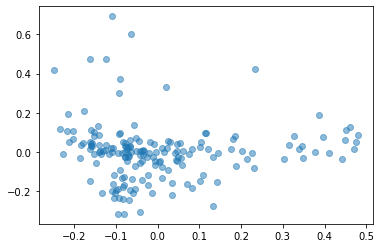

In [43]:
# Use PCA to visualize the feature vectors
from sklearn.decomposition import PCA

candidate_feature_vectors = candidate_quotes_cluster_feature.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

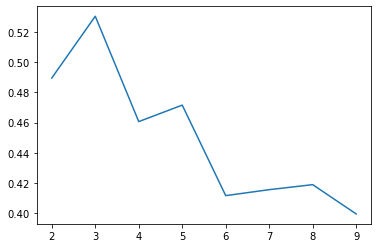

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

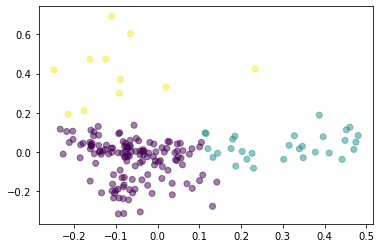

In [45]:
n_clusters = 3
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [46]:
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

135 candidates in type 0: Index(['ABHAY PATEL', 'AL GROSS', 'ALEX MERCED', 'AMY KLOBUCHAR',
       'ARN MENCONI', 'ARVIN VOHRA', 'BARBARA BOLLIER', 'BARRY MICHAELS',
       'BEN CARDIN', 'BERNIE SANDERS',
       ...
       'TAMMY DUCKWORTH', 'TED CRUZ', 'TED STRICKLAND', 'THOMAS DIXON',
       'TIM HAGAN', 'TINA SMITH', 'TOM JONES', 'TONY CAMPBELL', 'TROY HEBERT',
       'ZAK RINGELSTEIN'],
      dtype='object', length=135)
30 candidates in type 1: Index(['AARON JAMES', 'AMY MCGRATH', 'BEN SASSE', 'BOB WALSH', 'CORY BOOKER',
       'CORY GARDNER', 'DANIEL BURKE', 'DAVID MORAN', 'DOUG COLLINS',
       'DOUG JONES', 'GARY PETERS', 'JAIME HARRISON', 'JEANNE SHAHEEN',
       'JEFF MERKLEY', 'JEFF RUSSELL', 'JIM RISCH', 'JOHN CORNYN',
       'JON OSSOFF', 'JONI ERNST', 'LINDSEY GRAHAM', 'MARK KELLY',
       'MIKE ROUNDS', 'MITCH MCCONNELL', 'ROBERT MURPHY', 'ROGER MARSHALL',
       'SHELLEY MOORE CAPITO', 'STEVE BULLOCK', 'STEVE DAINES', 'THOM TILLIS',
       'TOMMY TUBERVILLE'],
      dtyp

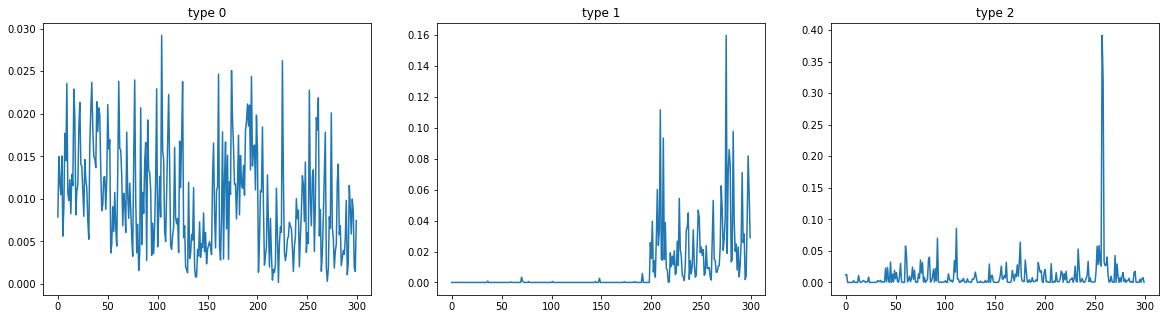

In [47]:
fig, axs = plt.subplots(1,n_clusters, figsize=(20,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))

We try to remove candidate of 2020 because the lack of data.

In [48]:
election_year = candidate_info_byname.loc[candidate_name]['year']
election_year

AARON JAMES         2020
ABHAY PATEL         2016
AL GROSS            2020
ALEX MERCED         2016
ALLEN BUCKLEY       2016
                    ... 
TOMMY TUBERVILLE    2020
TONY CAMPBELL       2018
TROY HEBERT         2016
VALENCIA STOVALL    2020
ZAK RINGELSTEIN     2018
Name: year, Length: 176, dtype: int64

In [49]:
candidate_name_filted = candidate_name[election_year!=2020]
candidate_name_filted

Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR',
       'ANN KIRKPATRICK', 'ARN MENCONI', 'ARVIN VOHRA', 'BARRY MICHAELS',
       'BEN CARDIN', 'BERNIE SANDERS',
       ...
       'TED CRUZ', 'TED STRICKLAND', 'THOMAS DIXON', 'TIM HAGAN', 'TIM SCOTT',
       'TINA SMITH', 'TOM JONES', 'TONY CAMPBELL', 'TROY HEBERT',
       'ZAK RINGELSTEIN'],
      dtype='object', length=132)

In [50]:
candidate_quotes_cluster_feature_filted = pd.DataFrame(np.zeros([feature_length,len(candidate_name_filted)]), columns=candidate_name_filted)

for candidate in candidate_name_filted:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature_filted[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature_filted

,ABHAY PATEL,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,ANN KIRKPATRICK,ARN MENCONI,ARVIN VOHRA,BARRY MICHAELS,BEN CARDIN,BERNIE SANDERS,...,TED CRUZ,TED STRICKLAND,THOMAS DIXON,TIM HAGAN,TIM SCOTT,TINA SMITH,TOM JONES,TONY CAMPBELL,TROY HEBERT,ZAK RINGELSTEIN
0,0.0,0.0,0.0,0.643107,0.0,0.0,0.000000,0.00000,0.964661,60.447298,...,382.834473,0.0,0.0,0.0,0.0,45.258062,0.0,0.000000,0.0,1.607768
1,0.0,0.0,0.0,0.864890,0.0,0.0,0.000000,0.00000,0.864890,1160.084533,...,750.771567,0.0,0.0,0.0,0.0,0.576593,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,41.414354,0.0,0.0,0.000000,0.00000,3.171264,89.959246,...,12.341234,0.0,0.0,0.0,0.0,45.040485,0.0,0.000000,0.0,3.459560
3,0.0,0.0,0.0,4.324450,0.0,0.0,1.153187,0.00000,3.171264,407.068522,...,257.303730,0.0,0.0,0.0,0.0,0.000000,0.0,2.306374,0.0,0.576593
4,0.0,0.0,0.0,4.901044,0.0,0.0,0.000000,0.86489,3.747857,2512.988300,...,2.408879,0.0,0.0,0.0,0.0,1.441483,0.0,2.882967,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,69.388074,0.0,0.0,0.000000,0.00000,3532.054072,0.814556,...,0.543037,0.0,0.0,0.0,0.0,1.900630,0.0,0.000000,0.0,0.000000
296,0.0,0.0,0.0,8.435176,0.0,0.0,0.000000,0.00000,1112.789610,203.735452,...,2.443667,0.0,0.0,0.0,0.0,0.814556,0.0,0.000000,0.0,0.000000
297,0.0,0.0,0.0,1.357593,0.0,0.0,0.000000,0.00000,0.271519,51.317006,...,144.343283,0.0,0.0,0.0,0.0,47.781231,0.0,0.000000,0.0,0.000000
298,0.0,0.0,0.0,0.814556,0.0,0.0,0.000000,0.00000,0.814556,943.311754,...,0.271519,0.0,0.0,0.0,0.0,11.150362,0.0,0.000000,0.0,0.000000


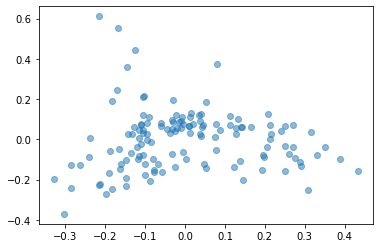

In [70]:
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

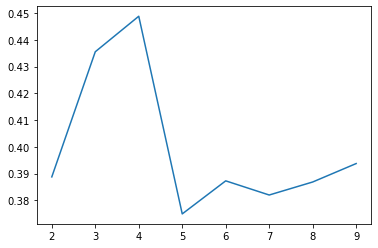

In [71]:
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

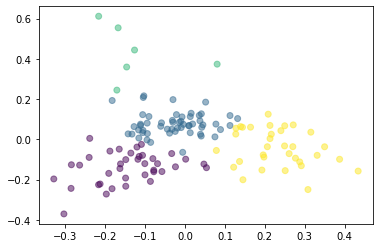

In [72]:
n_clusters = 4
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [73]:
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

38 candidates in type 0: Index(['AL GROSS', 'ALLEN BUCKLEY', 'BETO O'ROURKE', 'BILL HAGERTY',
       'BOB HUGIN', 'CORY BOOKER', 'DAN SULLIVAN', 'DEAN HELLER', 'DEAN HILL',
       'DEB FISCHER', 'DERRICK EDWARDS', 'DIANNE FEINSTEIN', 'HEIDI HEITKAMP',
       'JANE RAYBOULD', 'JASON KANDER', 'JEANNE SHAHEEN', 'JEFF MERKLEY',
       'JIM BARKSDALE', 'JIM NEWBERGER', 'JIM SCHULTZ', 'JOE MILLER',
       'JOHN BARRASSO', 'JOHN BOOZMAN', 'JOHN CARROLL', 'JOHNNY ISAKSON',
       'JONI ERNST', 'KELLY AYOTTE', 'KEVIN CRAMER', 'KEVIN O'CONNOR',
       'LISA MURKOWSKI', 'LORETTA SANCHEZ', 'MAGGIE HASSAN', 'MARIA CANTWELL',
       'MARK CALLAHAN', 'MARK KELLY', 'MARK KIRK', 'MIKE ESPY',
       'MURRAY SABRIN'],
      dtype='object')
55 candidates in type 1: Index(['AARON JAMES', 'ABHAY PATEL', 'AMY KLOBUCHAR', 'AMY MCGRATH',
       'ANN KIRKPATRICK', 'BERNIE SANDERS', 'BILL NELSON', 'BOB WALSH',
       'CAL CUNNINGHAM', 'CAROLINE FAYARD', 'CATHERINE CORTEZ MASTO',
       'CHRIS VAN HOLLEN', 'CHRIS

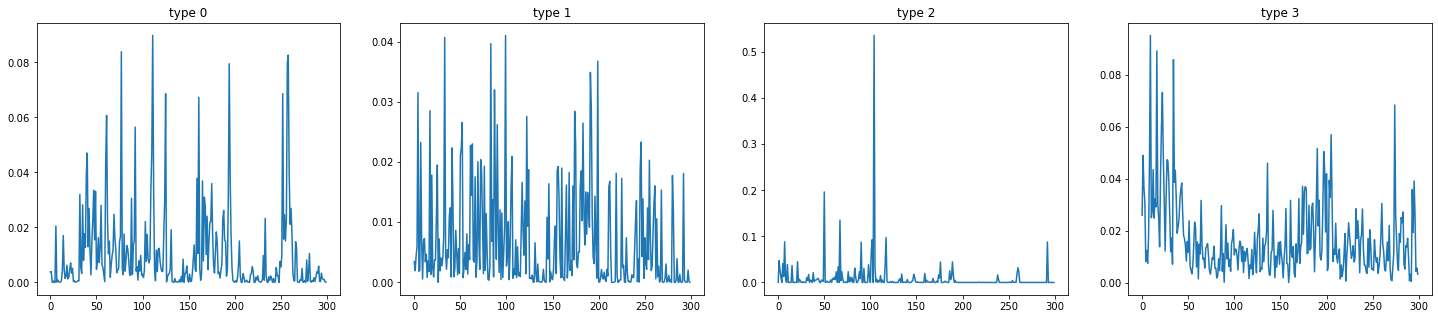

In [74]:
fig, axs = plt.subplots(1,n_clusters, figsize=(25,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))

We can also sum for each 30 days since the data is sparse.

In [84]:
# sum for each 30 day
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors_sum = np.array(np.split(candidate_feature_vectors,10, axis=1)).sum(axis=2).T

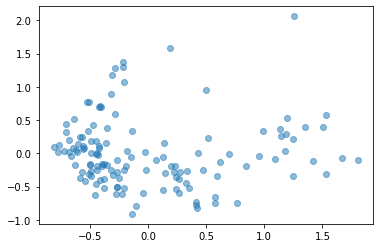

In [85]:
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors_sum).transform(candidate_feature_vectors_sum)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

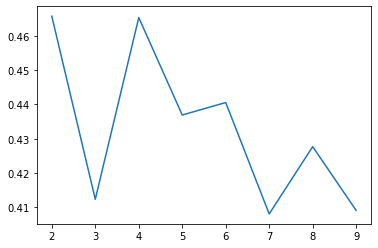

In [86]:
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

ValueError: 'c' argument has 1 elements, which is inconsistent with 'x' and 'y' with size 132.

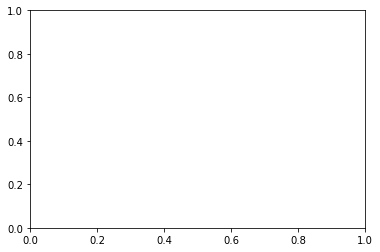

In [128]:
n_clusters = 4
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=3)

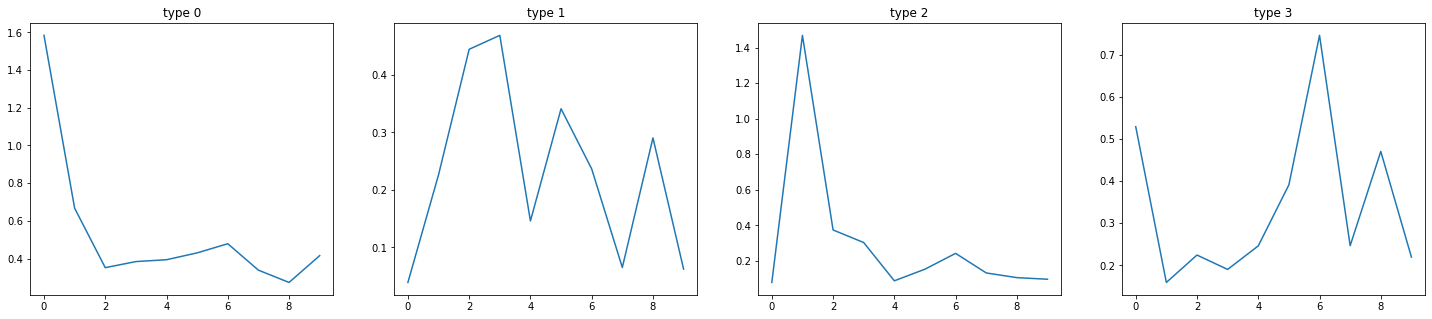

In [97]:
fig, axs = plt.subplots(1,n_clusters, figsize=(25,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,10), np.mean(candidate_feature_vectors_sum[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))

In [104]:
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name_filted[np.where(labels==candidate_type)]))

20 candidates in type 0: Index(['BERNIE SANDERS', 'BETO O'ROURKE', 'BOB HUGIN', 'CLAIRE MCCASKILL',
       'DEAN HELLER', 'HEIDI HEITKAMP', 'JACKY ROSEN', 'JIM NEWBERGER',
       'JOE DONNELLY', 'JOE MANCHIN', 'JOHN JAMES', 'JOSH HAWLEY',
       'KARIN HOUSLEY', 'KEVIN CRAMER', 'KYRSTEN SINEMA', 'MARSHA BLACKBURN',
       'MARTHA MCSALLY', 'PHIL BREDESEN', 'TAMMY BALDWIN', 'TED CRUZ'],
      dtype='object')
62 candidates in type 1: Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'ANN KIRKPATRICK',
       'ARVIN VOHRA', 'BRIAN SCHATZ', 'CHRIS VANCE', 'CINDY HYDE-SMITH',
       'CONNER ELDRIDGE', 'CRIS ERICSON', 'DARRYL GLENN', 'DAVID BARIA',
       'DAVID DUKE', 'DEAN HILL', 'DEBBIE STABENOW', 'DERRICK EDWARDS',
       'ELIOT GLASSHEIM', 'EVAN BAYH', 'JAMES LANKFORD', 'JAY WILLIAMS',
       'JEFF RUSSELL', 'JERRY MORAN', 'JERRY TROOIEN', 'JIM GRAY',
       'JIM SCHULTZ', 'JOE MILLER', 'JOHN BOOZMAN', 'JOHN HOEVEN',
       'JOHN KENNEDY', 'JOHNNY ISAKSON', 'KATHY SZELIGA', 'KATIE M

<AxesSubplot:>

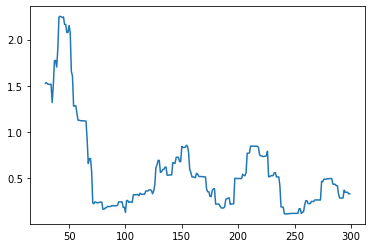

In [127]:
candidate_quotes_cluster_feature_filted['KEVIN CRAMER'].rolling(window=30).sum().plot()